In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_mnist

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [35]:
max_seq_len = 64
batch_size = 64
dataset_size = 2000
with_mask = False

train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/building_shapes_5010.csv",
                                                                                                 with_mask=with_mask,
                                                                                                 split_ratio=0.2,
                                                                                                 dataset_size=dataset_size,
                                                                                                 max_seq_len=max_seq_len,
                                                                                                 train=True)

train_tokens = train_tokens[:, :, :2]
val_tokens = val_tokens[:, :, :2]

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [36]:
# Define the encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, input_seq):
        _, (h, c) = self.lstm(input_seq)
        return h, c

# Define the decoder
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, h, c):
        batch_size, seq_len, _ = input_seq.shape
        hidden = h.reshape(batch_size, 1, -1)
        z = hidden.repeat(1, seq_len, 1)
        input_seq = torch.cat([z, input_seq], dim=-1)
        output, _ = self.lstm(input_seq, (h, c))
        output = self.fc(output)
        return hidden, output


class LstmAE(nn.Module):
    def __init__(self, fea_dim, hidden_size):
        super().__init__()
        self.encoder = Encoder(fea_dim, hidden_size)
        self.decoder = Decoder(hidden_size + fea_dim, hidden_size, fea_dim)
        self.loss_func = nn.MSELoss()
    
    def forward(self, x):
        h, c = self.encoder(x)
        output = self.decoder(x, h, c)
        hidden, output = self.decoder(x, h, c)
        loss = self.loss_func(output, x)
        return hidden, output, loss

In [38]:
lstm_ae = LstmAE(fea_dim=2, hidden_size=128)
optimizer = optim.Adam(lstm_ae.parameters(), lr=0.001)

num_epoch = 15

for epoch in range(num_epoch):
    lstm_ae.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        hidden, outputs, loss = lstm_ae(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    lstm_ae.eval()
    with torch.no_grad():
        val_hidden, val_outputs, loss = lstm_ae(train_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.17867117494344711, Val Loss: 0.07759108394384384
Epoch 2, Train Loss: 0.05391193762421608, Val Loss: 0.034906260669231415
Epoch 3, Train Loss: 0.022714076079428196, Val Loss: 0.012267427518963814
Epoch 4, Train Loss: 0.007971622571349144, Val Loss: 0.005432646255940199
Epoch 5, Train Loss: 0.004238329688087105, Val Loss: 0.0032747017685323954
Epoch 6, Train Loss: 0.0035982752125710248, Val Loss: 0.002792531158775091
Epoch 7, Train Loss: 0.0023043940262869, Val Loss: 0.0019266930175945163
Epoch 8, Train Loss: 0.0020354918763041494, Val Loss: 0.0016904969234019518
Epoch 9, Train Loss: 0.0014956229040399194, Val Loss: 0.0014758807374164462
Epoch 10, Train Loss: 0.0013220982486382127, Val Loss: 0.0010228923056274652
Epoch 11, Train Loss: 0.001962320872116834, Val Loss: 0.0016067486722022295
Epoch 12, Train Loss: 0.001190696929115802, Val Loss: 0.000903027830645442
Epoch 13, Train Loss: 0.0007826793496496975, Val Loss: 0.0006782244308851659
Epoch 14, Train Loss: 0.000

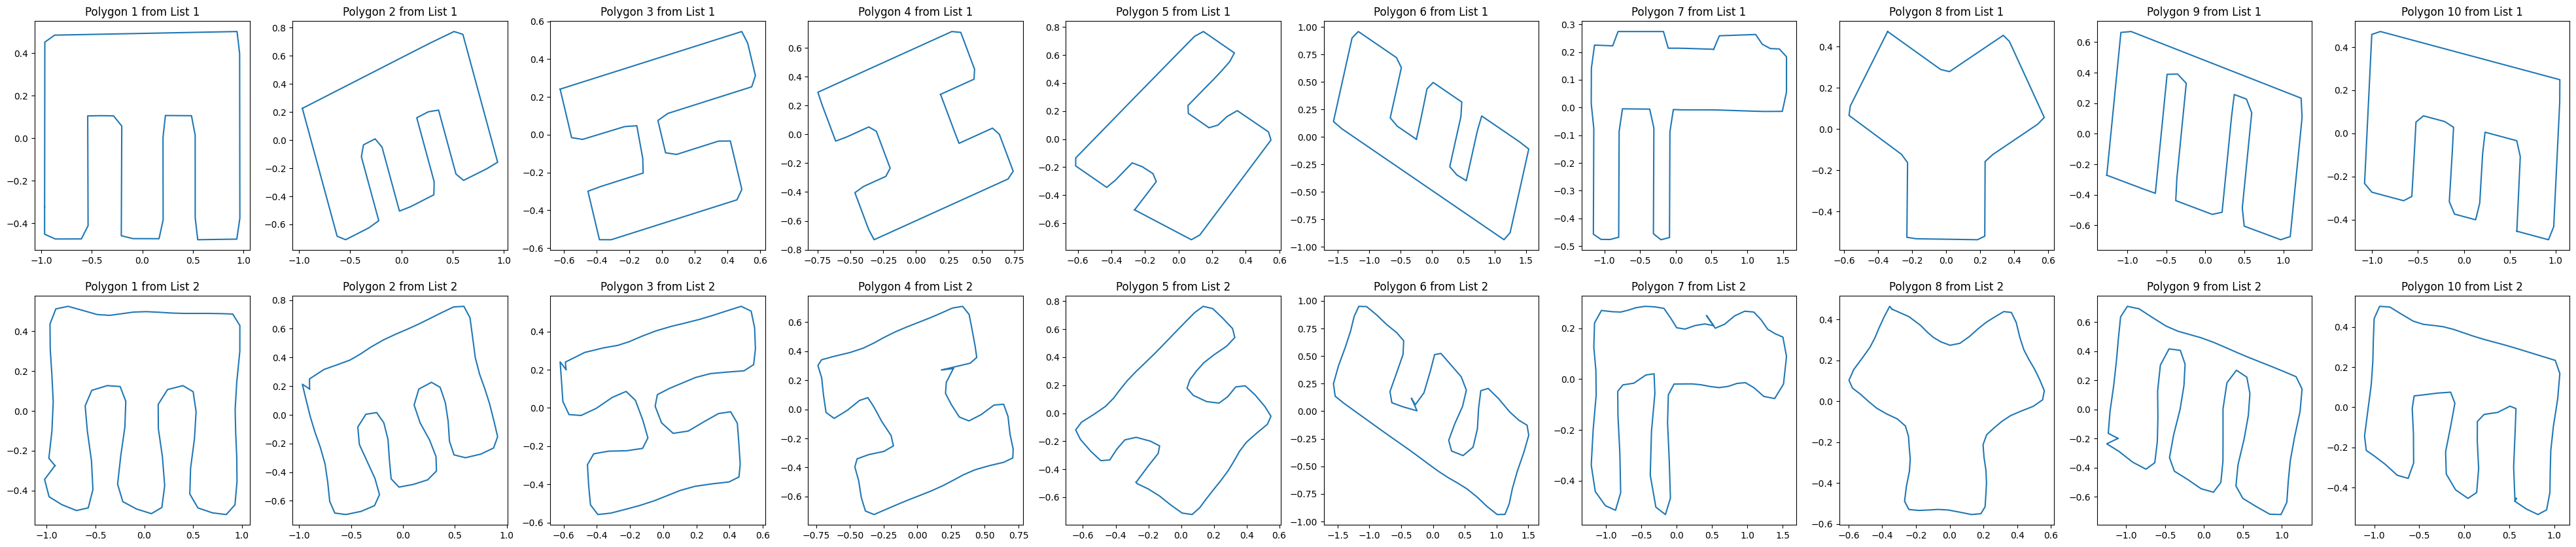

In [43]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

num_samples = 10

show_shapes = train_tokens[:num_samples]
rec_shapes = val_outputs[:num_samples]

ori_polygons = [Polygon(vec) for vec in show_shapes]
new_polygons = [Polygon(vec) for vec in rec_shapes]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[0, i].plot(hole_x, hole_y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[1, i].plot(hole_x, hole_y)

# Show the plot
plt.show()

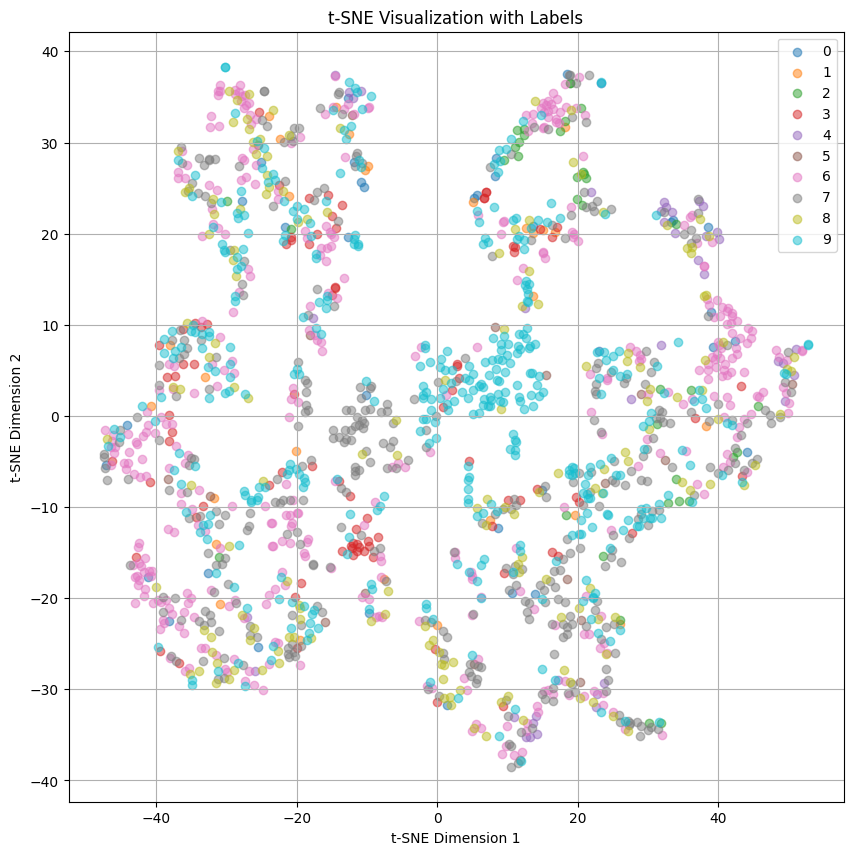

In [44]:
# show_hidden = val_tokens.view(val_tokens.size(0), -1)
show_hidden = val_hidden.reshape(val_hidden.size(0), -1)
show_labels = train_labels


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, init='pca', random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# lstm_ae.eval()
# with torch.no_grad():
#     train_hidden = lstm_ae(train_tokens)[0].view(train_tokens.size(0), -1)
#     val_hidden = lstm_ae(val_tokens)[0].view(val_tokens.size(0), -1)

# Without encoding
train_hidden = train_tokens.reshape(train_tokens.size(0), -1)
val_hidden = val_tokens.reshape(val_tokens.size(0), -1)

cls_train_loader = DataLoader(TensorDataset(train_hidden, train_labels), batch_size=batch_size, shuffle=True)

In [31]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        # x = self.relu(self.dense1(x))
        # x = self.dropout(x)
        # x = self.dense2(x)
        # Linear probing
        x = self.dense1(x)

        return x
    
classifier = Classifier(train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.004)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 70

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, cls_train_loader)
    val_loss, val_acc = evaluate(classifier, val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 4.3201838302612305, Train Acc 0.161875, Val Loss: 3.9935848712921143, Val Acc: 0.2375
Epoch: 2, Train Loss: 3.864531412124634, Train Acc 0.26875, Val Loss: 3.821342706680298, Val Acc: 0.2725
Epoch: 3, Train Loss: 3.6547891998291018, Train Acc 0.286875, Val Loss: 3.7096588611602783, Val Acc: 0.26
Epoch: 4, Train Loss: 3.492045774459839, Train Acc 0.3025, Val Loss: 3.608120918273926, Val Acc: 0.2825
Epoch: 5, Train Loss: 3.3417199516296385, Train Acc 0.323125, Val Loss: 3.4670908451080322, Val Acc: 0.3125
Epoch: 6, Train Loss: 3.205809097290039, Train Acc 0.3475, Val Loss: 3.3824026584625244, Val Acc: 0.32
Epoch: 7, Train Loss: 3.074408531188965, Train Acc 0.365, Val Loss: 3.2606201171875, Val Acc: 0.3275
Epoch: 8, Train Loss: 2.958585443496704, Train Acc 0.37625, Val Loss: 3.1580278873443604, Val Acc: 0.3325
Epoch: 9, Train Loss: 2.8564187717437743, Train Acc 0.38, Val Loss: 3.058107852935791, Val Acc: 0.35
Epoch: 10, Train Loss: 2.744858465194702, Train Acc 0.3931